In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_datareader as pdr
import quandl
import datetime 

sns.set(style='whitegrid')

C:\Users\Rodrigo\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Rodrigo\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\Rodrigo\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [21]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt

from keras.models import load_model

Using TensorFlow backend.
C:\Users\Rodrigo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Rodrigo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Rodrigo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Rodrigo\Anaconda3\lib\site-packages\tensorflow\python\framework\d

In [2]:
petr4 = pdr.get_data_yahoo('PETR4.SA')

In [3]:
petr4.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,37.320000,36.820000,36.950001,37.320000,13303600.0,31.840343
2010-01-05,37.430000,36.799999,37.380001,37.000000,21396400.0,31.567335
2010-01-06,37.500000,36.799999,36.799999,37.500000,18720600.0,31.993917
2010-01-07,37.450001,37.070000,37.270000,37.150002,10964600.0,31.695309
2010-01-08,37.389999,36.860001,37.160000,36.950001,14624200.0,31.524673


O objetivo é prever o que acontecerá com o valor de fechamento de uma ação em n dias (forward_days), tendo como base os m dias anteriores (look_back).

In [8]:
look_back = 40
forward_days = 10
num_periods = 20

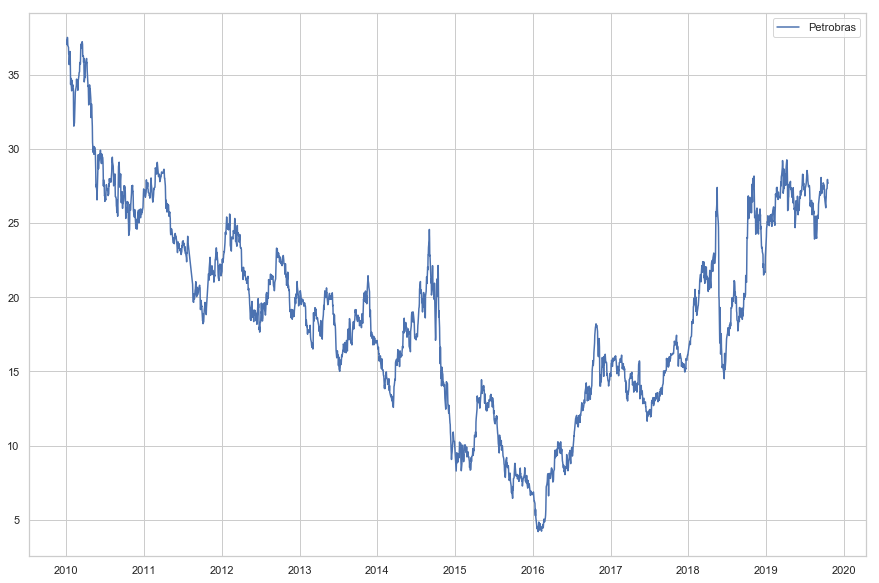

In [14]:
plt.figure(figsize = (15,10))
plt.plot(petr4['Close'], label='Petrobras')
plt.legend(loc='best')
plt.show()

In [15]:
df = petr4['Close']

In [16]:
array = df.values.reshape(df.shape[0],1)
array[:5]

array([[37.31999969],
       [37.        ],
       [37.5       ],
       [37.15000153],
       [36.95000076]])

In [17]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array = scl.fit_transform(array)
array[:5]

array([[0.99459459],
       [0.98498499],
       [1.        ],
       [0.98948954],
       [0.98348351]])

Vamos separar para os últimos k períodos (num_periods) para testar o modelo. A cada período, o modelo irá prever os próximos n dias. O resto será utilizado para o treinamento (Treino e Validação).

In [18]:
#split in Train and Test

division = len(array) - num_periods*forward_days

array_test = array[division-look_back:]
array_train = array[:division]

In [19]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [22]:
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [23]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(1712, 40, 1)
(429, 40, 1)
(20, 40, 1)
(1712, 10)
(429, 10)
(20, 10)


### Treinando a LSTM

In [24]:
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 50

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

W1020 00:08:08.097138 15840 deprecation_wrapper.py:119] From C:\Users\Rodrigo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1020 00:08:08.112099 15840 deprecation_wrapper.py:119] From C:\Users\Rodrigo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1020 00:08:08.115091 15840 deprecation_wrapper.py:119] From C:\Users\Rodrigo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1020 00:08:08.404319 15840 deprecation_wrapper.py:119] From C:\Users\Rodrigo\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1020 00:08:08.590820 15840 deprecation.py:323] From C:\Users\Rodrigo\An

Train on 1712 samples, validate on 429 samples
Epoch 1/50
 - 32s - loss: 0.0071 - val_loss: 0.0018
Epoch 2/50
 - 32s - loss: 0.0023 - val_loss: 0.0023
Epoch 3/50
 - 34s - loss: 0.0019 - val_loss: 0.0019
Epoch 4/50
 - 33s - loss: 0.0017 - val_loss: 0.0013
Epoch 5/50
 - 34s - loss: 0.0016 - val_loss: 0.0013
Epoch 6/50
 - 32s - loss: 0.0016 - val_loss: 0.0013
Epoch 7/50
 - 32s - loss: 0.0015 - val_loss: 0.0012
Epoch 8/50
 - 32s - loss: 0.0014 - val_loss: 0.0012
Epoch 9/50
 - 35s - loss: 0.0014 - val_loss: 0.0011
Epoch 10/50
 - 34s - loss: 0.0014 - val_loss: 0.0012
Epoch 11/50
 - 35s - loss: 0.0014 - val_loss: 0.0012
Epoch 12/50
 - 32s - loss: 0.0013 - val_loss: 0.0017
Epoch 13/50
 - 33s - loss: 0.0013 - val_loss: 0.0012
Epoch 14/50
 - 35s - loss: 0.0013 - val_loss: 0.0011
Epoch 15/50
 - 34s - loss: 0.0013 - val_loss: 0.0014
Epoch 16/50
 - 33s - loss: 0.0013 - val_loss: 0.0011
Epoch 17/50
 - 35s - loss: 0.0013 - val_loss: 0.0011
Epoch 18/50
 - 36s - loss: 0.0013 - val_loss: 0.0011
Epoch 19

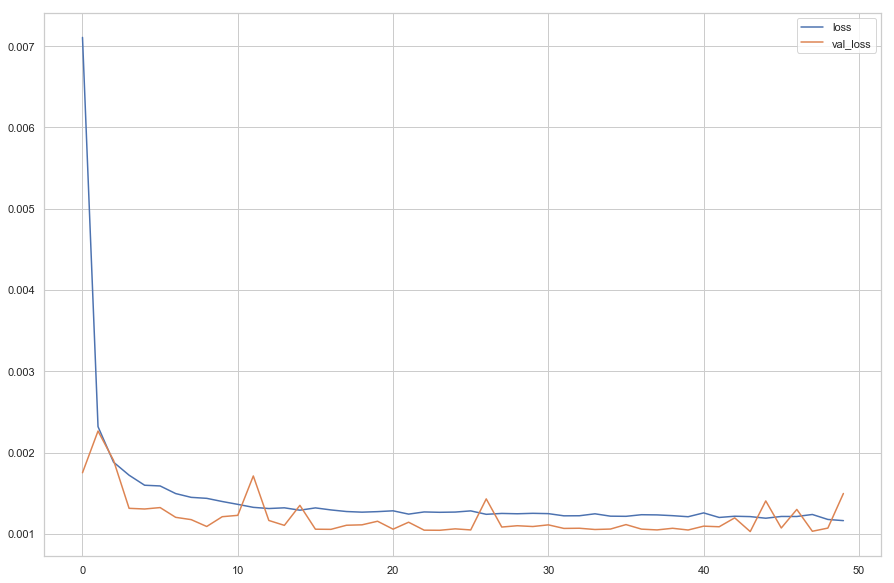

In [25]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [32]:
#Saving the model
file_name = 'C:\\Users\\Rodrigo\\Documents\\Trading com Dados\\LSTM_Petrobras.h5'
model.save_weights(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `C:\Users\Rodrigo\Documents\Trading com Dados\LSTM_Petrobras.h5` to disk


### Vamos prever os dados de Teste para o resultado

In [33]:
Xt = model.predict(X_test)

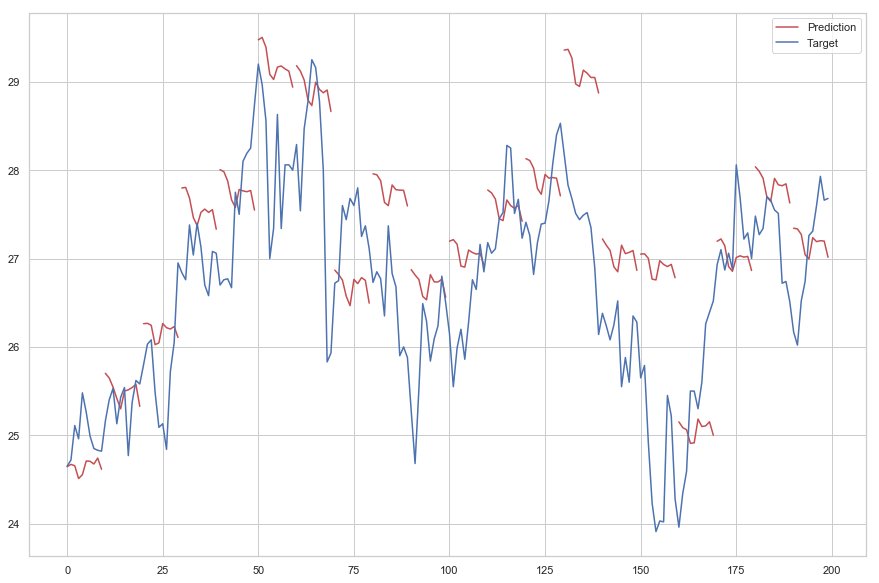

In [34]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

### Prever todos os dados para ver como o modelo reage aos dados de Treino e Teste

In [36]:
division = len(array) - num_periods*forward_days

leftover = division%forward_days+1

array_test = array[division-look_back:]
array_train = array[leftover:division]

In [37]:
Xtrain,ytrain = processData(array_train,look_back,forward_days,forward_days)
Xtest,ytest = processData(array_test,look_back,forward_days,forward_days)

In [38]:
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel()

In [39]:
y = np.concatenate((ytrain, ytest), axis=0)

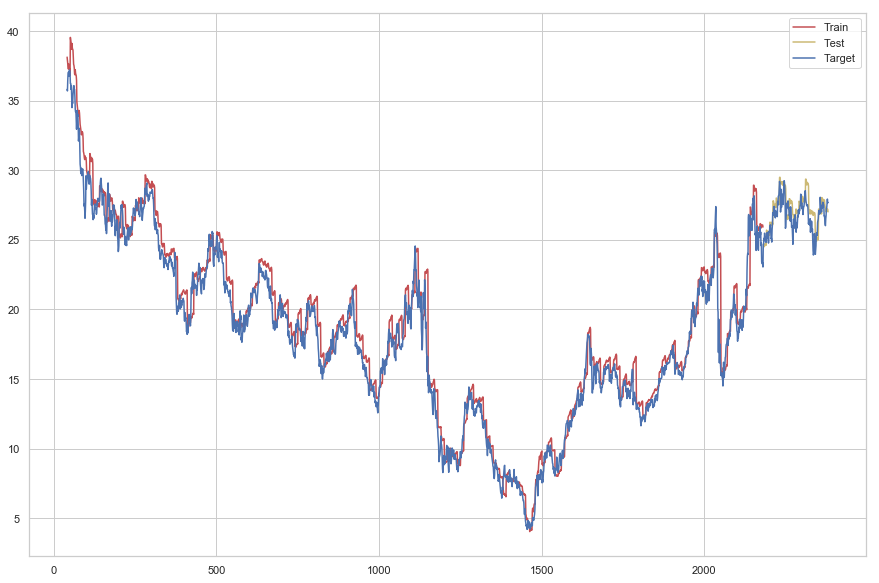

In [40]:
plt.figure(figsize = (15,10))

# Data in Train/Validation
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')
# Data in Test
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+look_back+leftover)], scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

#Data used
plt.plot([x for x in range(look_back+leftover, look_back+leftover+len(Xtrain)+len(Xtest))], scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

#Initial data. It should overlap the data used
#plt.plot(scl.inverse_transform(array), color='b', label='Esperado')

plt.legend(loc='best')
plt.show()

Usar apenas uma LSTM não é suficiente para prever o comportamento de uma ação no mercado. Quando usamos apenas o histórico de preço de uma empresa, a previsão fica longe da realidade.